In [ ]:
!pip install transformers datasets torchvision accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from transformers import AutoTokenizer, AutoModel
from torchvision import transforms
from PIL import Image


In [ ]:
data_samples = load_dataset("nlphuji/flickr30k", split="test")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/641 [00:00<?, ?B/s]

flickr30k.py:   0%|          | 0.00/2.51k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/506M [00:00<?, ?B/s]

0001.parquet:   0%|          | 0.00/502M [00:00<?, ?B/s]

0002.parquet:   0%|          | 0.00/506M [00:00<?, ?B/s]

0003.parquet:   0%|          | 0.00/512M [00:00<?, ?B/s]

0004.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

0005.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

0006.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

0007.parquet:   0%|          | 0.00/497M [00:00<?, ?B/s]

0008.parquet:   0%|          | 0.00/289M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/31014 [00:00<?, ? examples/s]

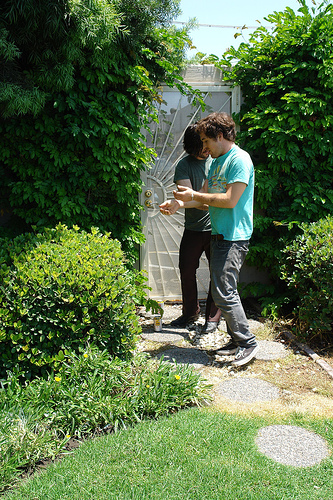

In [ ]:
data_samples = data_samples.select(range(10000))
data_samples[0]
data_samples[0]['image']

In [ ]:
from datasets import Dataset

def preprocess_dataset(dataset):
    """
    Preprocess the dataset by splitting it into train, val, and test sets.
    The output contains only 'filename', 'image', and 'caption' fields.

    Args:
        dataset (Dataset): A Hugging Face Dataset object containing the data.

    Returns:
        dict: A dictionary with keys 'train', 'val', 'test', where each key maps
              to a Dataset object containing 'filename', 'image', and 'caption'.
    """
    # Initialize splits
    splits = {"train": [], "val": [], "test": []}

    for sample in dataset:
        split = sample['split']  # Get the split type
        if split in splits:
            # Keep only the desired fields
            processed_sample = {
                "filename": sample["filename"],
                "image": sample["image"],
                "caption": sample["caption"]
            }
            splits[split].append(processed_sample)

    # Convert splits to Dataset objects
    from datasets import Dataset
    for key in splits:
        splits[key] = Dataset.from_list(splits[key])

    return splits

In [ ]:
data_splits = preprocess_dataset(data_samples)

{'train': Dataset({
    features: ['filename', 'image', 'caption'],
    num_rows: 9375
}), 'val': Dataset({
    features: ['filename', 'image', 'caption'],
    num_rows: 301
}), 'test': Dataset({
    features: ['filename', 'image', 'caption'],
    num_rows: 324
})}


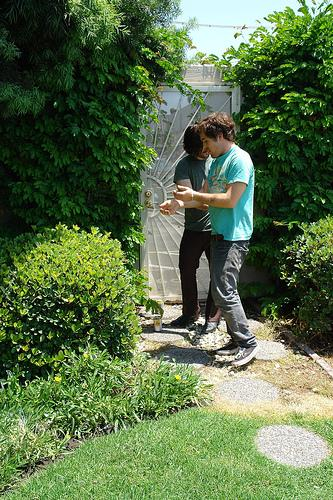

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

print(data_splits)
data_splits['train'][0]['image']

In [ ]:
class TextToImageDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, image_transform):
        self.data = data
        self.tokenizer = tokenizer
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = item['caption']

        target_image = item['image']
        target_image = self.image_transform(target_image)

        # Tokenize text
        text_encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=50,
            return_tensors="pt"
        )


        return {
            "text": text_encoding["input_ids"].squeeze(0),
            "attention_mask": text_encoding["attention_mask"].squeeze(0),
            "target_image": target_image
        }

In [ ]:
class Generator(nn.Module):
    def __init__(self, text_embedding_dim, noise_dim=100):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(text_embedding_dim + noise_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 4 * 4 * 512),
            nn.ReLU()
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, text_embedding, noise):
        # Kết hợp text embedding với noise
        x = torch.cat((text_embedding, noise), dim=1)
        # Fully connected layers
        x = self.fc(x).view(-1, 512, 4, 4)
        # Dùng các lớp deconvolution để tạo ảnh
        return self.deconv(x)



class Discriminator(nn.Module):
    def __init__(self, text_embedding_dim):
        super().__init__()
        # Process image
        self.image_branch = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Flatten()  # Output shape: (batch_size, 512 * 4 * 4)
        )

        # Process text embedding
        self.text_branch = nn.Sequential(
            nn.Linear(text_embedding_dim, 512),  # Reduce embedding size
            nn.LeakyReLU(0.2)
        )

        # Combine image and text features
        self.combined = nn.Sequential(
            nn.Linear(512 * 4 * 4 + 512, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, image, text_embedding):
        img_features = self.image_branch(image)
        text_features = self.text_branch(text_embedding)
        combined_features = torch.cat((img_features, text_features), dim=1)
        return self.combined(combined_features)


In [ ]:
def train(generator, discriminator, dataloader, text_model, optimizer_G, optimizer_D, criterion, device, noise_dim, epochs):
    for epoch in range(epochs):
        for batch in dataloader:
            # Load text and image data
            text_inputs = batch["text"].to(device)  # (batch_size, num_sentences, seq_len)
            attention_mask = batch["attention_mask"].to(device)  # (batch_size, num_sentences, seq_len)
            target_images = batch["target_image"].to(device)  # (batch_size, 3, 64, 64)

            # Extract shapes
            batch_size, num_sentences, seq_len = text_inputs.shape

            # Reshape text inputs and attention mask to process all sentences
            text_inputs = text_inputs.view(-1, seq_len)  # (batch_size * num_sentences, seq_len)
            attention_mask = attention_mask.view(-1, seq_len)

            # Generate text embeddings
            with torch.no_grad():
                text_outputs = text_model(input_ids=text_inputs, attention_mask=attention_mask)
                sentence_embeddings = text_outputs.last_hidden_state.mean(dim=1)  # (batch_size * num_sentences, text_embedding_dim)

            # Average embeddings across sentences for each image
            text_embeddings = sentence_embeddings.view(batch_size, num_sentences, -1).mean(dim=1)  # (batch_size, text_embedding_dim)

            # Generate random noise
            noise = torch.randn(batch_size, noise_dim).to(device)  # (batch_size, noise_dim)

            # Generate fake images
            fake_images = generator(text_embeddings, noise)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = criterion(discriminator(target_images, text_embeddings), torch.ones(batch_size, 1).to(device))
            fake_loss = criterion(discriminator(fake_images.detach(), text_embeddings), torch.zeros(batch_size, 1).to(device))
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            g_loss = criterion(discriminator(fake_images, text_embeddings), torch.ones(batch_size, 1).to(device))
            g_loss.backward()
            optimizer_G.step()

        print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")


In [ ]:
if __name__ == "__main__":
    # Configurations
    epochs = 50
    noise_dim = 100
    learning_rate = 0.0002
    batch_size = 32
    text_embedding_dim = 768
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load Pre-trained Transformers
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    text_model = AutoModel.from_pretrained("bert-base-uncased").to(device)

    # Dataset and DataLoader
    image_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = TextToImageDataset(data_splits['train'], tokenizer, image_transform)
    val_dataset = TextToImageDataset(data_splits['val'], tokenizer, image_transform)
    test_dataset = TextToImageDataset(data_splits['test'], tokenizer, image_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Models
    generator = Generator(text_embedding_dim, noise_dim=noise_dim).to(device)
    discriminator = Discriminator(text_embedding_dim).to(device)

    # Optimizers and Loss
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    criterion = nn.BCELoss()

    # Train
    train(generator, discriminator, train_loader, text_model, optimizer_G, optimizer_D, criterion, device, noise_dim, epochs)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/50, D Loss: 0.22494077682495117, G Loss: 5.273314476013184
Epoch 2/50, D Loss: 0.6216084957122803, G Loss: 4.141051292419434
Epoch 3/50, D Loss: 0.7009224891662598, G Loss: 4.6870880126953125
Epoch 4/50, D Loss: 0.3820682168006897, G Loss: 5.2148613929748535
Epoch 5/50, D Loss: 3.0078201293945312, G Loss: 7.842321395874023
Epoch 6/50, D Loss: 0.8965770602226257, G Loss: 3.182765245437622
Epoch 7/50, D Loss: 0.3574696183204651, G Loss: 4.806752681732178
Epoch 8/50, D Loss: 0.3509165048599243, G Loss: 3.679529905319214
Epoch 9/50, D Loss: 0.7375475764274597, G Loss: 3.7887439727783203
Epoch 10/50, D Loss: 0.7770141363143921, G Loss: 3.6756322383880615
Epoch 11/50, D Loss: 0.5525292158126831, G Loss: 3.0389909744262695
Epoch 12/50, D Loss: 0.6565487384796143, G Loss: 5.18707275390625
Epoch 13/50, D Loss: 0.6062812805175781, G Loss: 2.732640266418457
Epoch 14/50, D Loss: 0.32968056201934814, G Loss: 3.993481397628784
Epoch 15/50, D Loss: 0.5327203273773193, G Loss: 4.23215961456298

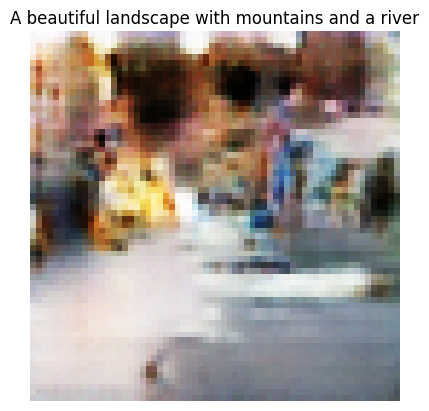

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

def generate_image(generator, text_model, tokenizer, prompt, noise_dim, device):
    """
    Tạo hình ảnh từ mô hình Generator đã được train, sử dụng một đoạn văn bản đầu vào.

    Args:
        generator (nn.Module): Mô hình Generator đã được train.
        text_model (nn.Module): Mô hình BERT hoặc transformer đã được train.
        tokenizer (Tokenizer): Tokenizer của mô hình BERT hoặc transformer.
        prompt (str): Đoạn văn bản dùng để tạo ảnh.
        noise_dim (int): Kích thước vector noise.
        device (torch.device): Thiết bị (CPU/GPU).

    Returns:
        generated_image (PIL.Image): Hình ảnh đã được tạo.
    """
    generator.eval()
    text_model.eval()

    # Tokenize prompt
    tokens = tokenizer(prompt, return_tensors="pt", padding="max_length", truncation=True, max_length=50)
    text_inputs = tokens["input_ids"].to(device)  # (1, seq_len)
    attention_mask = tokens["attention_mask"].to(device)  # (1, seq_len)

    # Generate text embedding
    with torch.no_grad():
        text_outputs = text_model(input_ids=text_inputs, attention_mask=attention_mask)
        text_embedding = text_outputs.last_hidden_state.mean(dim=1)  # (1, text_embedding_dim)

    # Generate noise
    noise = torch.randn(1, noise_dim).to(device)  # (1, noise_dim)

    # Generate image
    with torch.no_grad():
        fake_image = generator(text_embedding, noise)  # (1, 3, 64, 64)

    # Convert to image format
    fake_image = fake_image.squeeze(0).cpu()  # (3, 64, 64)
    fake_image = T.ToPILImage()(fake_image * 0.5 + 0.5)  # Rescale to [0, 1]

    return fake_image


# Ví dụ sử dụng hàm generate_image
if __name__ == "__main__":
    prompt = "A beautiful landscape with mountains and a river"
    generated_img = generate_image(generator, text_model, tokenizer, prompt, noise_dim, device)

    # Hiển thị hình ảnh được tạo
    plt.imshow(generated_img)
    plt.axis("off")
    plt.title(prompt)
    plt.show()
